In [ ]:
# 导入必要的库
# matplotlib inline: 在Jupyter中内联显示图形
%matplotlib inline
import os  # 操作系统接口，用于文件和目录操作
import collections  # 提供特殊容器数据类型，这里用Counter统计
import math  # 数学函数库
import shutil  # 高级文件操作，用于复制文件
import pandas as pd  # 数据分析库，用于处理CSV和生成提交文件
import torch  # PyTorch深度学习框架
from torch import nn  # 神经网络模块
import torchvision  # 计算机视觉工具库，包含数据集和变换
from d2l import torch as d2l  # 《动手学深度学习》工具库

In [ ]:
# 配置CIFAR-10数据集
# 注册CIFAR-10微型数据集的下载链接到d2l的数据中心
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# demo模式控制：True使用小数据集快速测试，False使用完整Kaggle竞赛数据集
# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    # demo模式：下载并解压微型数据集
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    # 完整模式：使用本地完整CIFAR-10数据集
    data_dir = '../data/cifar-10/'

In [ ]:
# 读取训练标签CSV文件
#@save
def read_csv_labels(fname):
    """
    读取CSV标签文件，返回文件名到标签的映射字典
    
    参数:
        fname: CSV文件路径
    返回:
        dict: {图像文件名: 类别标签} 的字典
    """
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)，读取所有数据行
        lines = f.readlines()[1:]
    # 将每行按逗号分割为[文件名, 标签]对
    tokens = [l.rstrip().split(',') for l in lines]
    # 构建文件名到标签的字典映射
    return dict(((name, label) for name, label in tokens))

# 读取训练标签并显示数据集统计信息
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))  # 训练样本总数
print('# 类别 :', len(set(labels.values())))  # 类别总数（应该是10类）

# 训练样本 : 1000
# 类别 : 10


In [ ]:
# 文件复制和数据集划分工具函数
#@save
def copyfile(filename, target_dir):
    """
    将文件复制到目标目录
    
    参数:
        filename: 源文件路径
        target_dir: 目标目录路径
    """
    os.makedirs(target_dir, exist_ok=True)  # 创建目标目录（如果不存在）
    shutil.copy(filename, target_dir)  # 复制文件

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """
    将训练集划分为训练集和验证集
    策略：从每个类别中抽取相同数量的样本作为验证集，确保类别平衡
    
    参数:
        data_dir: 数据目录路径
        labels: 文件名到标签的字典
        valid_ratio: 验证集比例
    返回:
        n_valid_per_label: 每个类别的验证集样本数
    """
    # 统计每个类别的样本数，找到样本最少的类别
    # most_common()[-1]返回出现次数最少的类别，[1]取其计数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 计算每个类别应分配到验证集的样本数（至少1个）
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}  # 记录每个类别已分配到验证集的样本数
    
    # 遍历训练目录中的所有图像文件
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]  # 获取图像的标签
        fname = os.path.join(data_dir, 'train', train_file)
        # 复制到train_valid目录（包含所有原始训练数据）
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        # 如果该类别的验证集样本数未满，则分配到验证集
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 否则分配到训练集
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

In [ ]:
# 整理测试集
#@save
def reorg_test(data_dir):
    """
    在预测期间整理测试集，以方便读取
    将所有测试图像归为'unknown'类别（因为测试集没有标签）
    
    参数:
        data_dir: 数据目录路径
    """
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        # 将所有测试文件复制到test/unknown目录下
        # ImageFolder需要子目录结构，所以创建unknown类别
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [ ]:
# 整理CIFAR-10数据集的主函数
def reorg_cifar10_data(data_dir, valid_ratio):
    """
    整理CIFAR-10数据集，创建以下目录结构：
    - train_valid_test/train/: 训练集（已分出验证集）
    - train_valid_test/valid/: 验证集
    - train_valid_test/train_valid/: 完整训练集（用于最终训练）
    - train_valid_test/test/: 测试集
    
    参数:
        data_dir: 数据目录路径
        valid_ratio: 验证集比例
    """
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)  # 划分训练集和验证集
    reorg_test(data_dir)  # 整理测试集

In [ ]:
# 设置批量大小和验证集比例，并执行数据集整理
batch_size = 32 if demo else 128  # demo模式用小批量，完整模式用大批量
valid_ratio = 0.1  # 验证集占训练集的10%
reorg_cifar10_data(data_dir, valid_ratio)  # 执行数据整理

In [ ]:
# 定义训练集的数据增强变换
# 数据增强可以增加训练样本的多样性，提高模型泛化能力
transform_train = torchvision.transforms.Compose([
    # 1. 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 2. 随机裁剪出一个高度和宽度均为32像素的正方形图像
    # scale=(0.64, 1.0): 生成一个面积为原始图像面积0.64～1倍的小正方形
    # ratio=(1.0, 1.0): 保持宽高比为1:1
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    # 3. 以50%的概率随机水平翻转图像
    torchvision.transforms.RandomHorizontalFlip(),
    # 4. 将PIL图像或numpy数组转换为张量，并归一化到[0, 1]
    torchvision.transforms.ToTensor(),
    # 5. 标准化图像的每个通道：(x - mean) / std
    # 使用CIFAR-10数据集的统计均值和标准差
    # mean=[0.4914, 0.4822, 0.4465]: RGB三通道的均值
    # std=[0.2023, 0.1994, 0.2010]: RGB三通道的标准差
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [ ]:
# 定义测试集的数据变换
# 测试时不需要数据增强，只需要标准化
transform_test = torchvision.transforms.Compose([
    # 1. 将PIL图像或numpy数组转换为张量，并归一化到[0, 1]
    torchvision.transforms.ToTensor(),
    # 2. 使用与训练集相同的均值和标准差进行标准化
    # 这样可以保证训练和测试数据分布一致
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [ ]:
# 创建训练集和验证集的数据集对象
# ImageFolder会自动根据子目录名称作为类别标签

# 训练数据集（已分出验证集）和完整训练数据集（用于最终训练）
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

# 验证数据集和测试数据集（使用测试时的变换，不做数据增强）
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [ ]:
# 创建数据加载器（DataLoader）
# DataLoader用于批量加载数据，支持多线程、打乱等功能

# 训练数据加载器和完整训练数据加载器
# shuffle=True: 每个epoch随机打乱数据顺序，增加随机性
# drop_last=True: 丢弃最后不足一个批量的数据，保证批量大小一致
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

# 验证数据加载器
# shuffle=False: 验证时不需要打乱数据
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

# 测试数据加载器
# drop_last=False: 保留所有测试样本，包括最后不足一个批量的数据
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [ ]:
# 定义网络模型和损失函数
def get_net():
    """
    创建ResNet-18网络模型
    
    返回:
        net: ResNet-18模型
    """
    num_classes = 10  # CIFAR-10有10个类别
    # 使用d2l提供的ResNet-18，输入通道数为3（RGB图像）
    net = d2l.resnet18(num_classes, 3)
    return net

# 定义交叉熵损失函数
# reduction="none": 返回每个样本的损失，而不是批量平均损失
loss = nn.CrossEntropyLoss(reduction="none")

In [ ]:
# 定义训练函数
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    """
    训练神经网络模型
    
    参数:
        net: 神经网络模型
        train_iter: 训练数据加载器
        valid_iter: 验证数据加载器（可以为None）
        num_epochs: 训练轮数
        lr: 初始学习率
        wd: 权重衰减（L2正则化系数）
        devices: GPU设备列表
        lr_period: 学习率衰减周期（每隔多少个epoch衰减一次）
        lr_decay: 学习率衰减率
    """
    # 使用SGD优化器，momentum=0.9使用动量加速收敛
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    # 学习率调度器：每lr_period个epoch，学习率乘以lr_decay
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()  # 批量数和计时器
    
    # 设置动画图例
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    # 创建动画器，用于实时显示训练过程
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    # 使用DataParallel进行多GPU并行训练
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    # 训练循环
    for epoch in range(num_epochs):
        net.train()  # 设置为训练模式（启用dropout、batch norm等）
        metric = d2l.Accumulator(3)  # 累加器：[损失总和, 准确数, 样本数]
        
        # 遍历训练数据
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            # 训练一个批量，返回损失和准确率
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])  # 累加统计量
            timer.stop()
            
            # 每隔1/5个epoch或最后一个批次，更新一次动画
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        
        # 在验证集上评估模型
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        
        scheduler.step()  # 更新学习率
    
    # 打印训练结果
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.015, train acc 0.998, valid acc 0.375
2301.3 examples/sec on [device(type='cuda', index=0)]


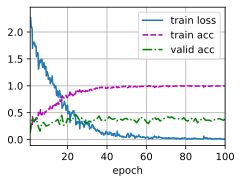

In [ ]:
# 训练模型（使用训练集和验证集）
# 这一步用于调试和验证超参数，通过验证集评估模型性能

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
# devices: 自动检测所有可用GPU
# num_epochs: 训练20个epoch
# lr: 学习率0.0002
# wd: 权重衰减0.0005（L2正则化）

lr_period, lr_decay, net = 4, 0.9, get_net()
# lr_period: 每4个epoch衰减一次学习率
# lr_decay: 学习率衰减率0.9（每次乘以0.9）
# net: 创建新的ResNet-18模型

# 开始训练（使用train和valid数据集）
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [ ]:
# 训练最终模型并生成预测结果
# 使用全部训练数据（train_valid）训练最终模型，然后在测试集上预测

net, preds = get_net(), []  # 创建新模型，初始化预测列表
# 使用全部训练数据训练，不使用验证集（valid_iter=None）
# 这样可以充分利用所有训练数据，提高模型性能
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

# 在测试集上进行预测
for X, _ in test_iter:
    # 将数据移到GPU上进行前向传播
    y_hat = net(X.to(devices[0]))
    # argmax获取概率最大的类别索引，添加到预测列表
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

# 生成提交文件
sorted_ids = list(range(1, len(test_ds) + 1))  # 测试样本ID从1开始
sorted_ids.sort(key=lambda x: str(x))  # 按字符串排序（Kaggle要求）
df = pd.DataFrame({'id': sorted_ids, 'label': preds})  # 创建DataFrame
# 将数字标签转换为类别名称
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)  # 保存为CSV文件，用于提交到Kaggle